<a href="https://colab.research.google.com/github/LeoVogiatzis/medical_data_analysis/blob/main/Cardio_Cost_Sensitive_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

import os#Walking through directores

import plotly.graph_objects as go # Generate Graphs
from plotly.subplots import make_subplots #To Create Subplots

from sklearn import decomposition #pca
from sklearn.preprocessing import StandardScaler # Standardization ((X - X_mean)/X_std)

pd.set_option('display.max_columns', None)#Setting Max Columns Display to Max inorder to get glance of all features in dataframe

from google.colab import files
uploaded = files.upload()

Saving cardio_train.csv to cardio_train.csv


In [ ]:
!pip install git+git://github.com/albahnsen/CostSensitiveClassification.git

  Cloning git://github.com/albahnsen/CostSensitiveClassification.git to /tmp/pip-req-build-atpen6pg
  Running command git clone -q git://github.com/albahnsen/CostSensitiveClassification.git /tmp/pip-req-build-atpen6pg
  Created wheel for costcla: filename=costcla-0.6-cp37-none-any.whl size=3981335 sha256=ee0a13a031f58490f6275211c33492ebb7316f71917fdb49cfb23f4bba2dc1cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-em7yq5xg/wheels/88/50/a9/46090896420899de912f048c5d91b30b25d5e32d88a2fc23c6
  Created wheel for pyea: filename=pyea-0.2-cp37-none-any.whl size=6017 sha256=ef667ed6564a853f27feedb108c3cfb6c674e96665d3ae22efeccd0cdb88edc2
  Stored in directory: /root/.cache/pip/wheels/3c/bf/6e/06f8b0ed23cbc1fe956f8b6756535cb36f0b68c2f0f2342178
Successfully built costcla pyea


In [ ]:
import io

missing_values = ['?', '--', ' ', 'NA', 'N/A', '-'] #Sometimes Missing Values are't in form of NaN
df = pd.read_csv(io.BytesIO(uploaded['cardio_train.csv']),sep=';') 
print('There are Total {} datapoints in the dataset with {} Features listed as {}:'.format(df.shape[0], df.shape[1], df.columns.values))

There are Total 70000 datapoints in the dataset with 13 Features listed as ['id' 'age' 'gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol'
 'gluc' 'smoke' 'alco' 'active' 'cardio']:


In [ ]:
features_with_null = [features for feature in df.columns if df[feature].isnull().sum()>0]
if features_with_null:
    print('Features with Null Values {}'.format(features_with_null))
else:
    print('Dataset contains no Null Values')

Dataset contains no Null Values


In [ ]:
df.drop(columns=['id'], inplace=True)

In [ ]:
duplicate_sum = df.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 24


In [ ]:
df.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(df.shape[0], df.shape[1]))

Total 69976 datapoints remaining with 12 features


In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Height Distribution", "Weight Distribution"))

trace0 = go.Histogram(x=df['height'], name = 'Height')
trace1 = go.Histogram(x=df['weight'], name = 'Weight')


fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig.update_xaxes(title_text="Height", row=1, col=1)
fig.update_yaxes(title_text="Total Count", row=1, col=1)

fig.update_xaxes(title_text="Weight", row=1, col=2)
fig.update_yaxes(title_text="Total Count", row=1, col=2)

fig.update_layout(title_text="Histograph", height=700)


fig.show()

In [ ]:
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))
outliers(df[['height', 'weight']])

For the feature height, No of Outliers is 519
For the feature weight, No of Outliers is 1819


In [ ]:
outline_free_df = df.copy()
outline_free_df[['height', 'weight']] = np.log(outline_free_df[['height', 'weight']])
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 484
For the feature weight, No of Outliers is 1174


In [ ]:
outline_free_df = outline_free_df[(outline_free_df['weight'] > outline_free_df['weight'].quantile(0.005)) & (outline_free_df['weight'] < outline_free_df['weight'].quantile(0.995))]
outline_free_df = outline_free_df[(outline_free_df['height'] > outline_free_df['height'].quantile(0.005)) & (outline_free_df['height'] < outline_free_df['height'].quantile(0.995))]
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 0
For the feature weight, No of Outliers is 349


In [ ]:
print('Handling outliners cost us {} datapoints'.format(len(df)-len(outline_free_df)))

Handling outliners cost us 1630 datapoints


In [ ]:
outline_free_df = outline_free_df[outline_free_df['ap_lo']>=0]
outline_free_df = outline_free_df[outline_free_df['ap_hi']>=0]

In [ ]:
print('There are total {} observations where ap_hi < ap_lo'.format(len(outline_free_df[outline_free_df['ap_hi'] < outline_free_df['ap_lo']])))

There are total 1182 observations where ap_hi < ap_lo


In [ ]:
cleaned_data = outline_free_df[outline_free_df['ap_hi'] >= outline_free_df['ap_lo']].reset_index(drop=True)
print('Total observations preserved : {}'.format(len(cleaned_data)))

Total observations preserved : 67156


In [ ]:
print('As per our assumptions we have total {} outliers'.format(len(cleaned_data[(cleaned_data["ap_hi"]>250) | (cleaned_data["ap_lo"]>200)])))

As per our assumptions we have total 38 outliers


In [ ]:
cleaned_data = cleaned_data[(cleaned_data["ap_hi"]<=250) & (cleaned_data["ap_lo"]<=200)]

In [ ]:
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], cleaned_data.shape[1]))

Total 67118 datapoints remaining with 12 features


In [ ]:
cleaned_data.head()

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2  5.123964  4.127134    110     80            1     1      0   
1  20228       1  5.049856  4.442651    140     90            3     1      0   
2  18857       1  5.105945  4.158883    130     70            3     1      0   
3  17623       2  5.129899  4.406719    150    100            1     1      0   
4  17474       1  5.049856  4.025352    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [ ]:
cleaned_data['age'] = cleaned_data['age'].div(365).apply(lambda x: int(x))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=cleaned_data['age'], name = 'Age'))
fig.show()

In [ ]:
duplicate_sum = cleaned_data.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 3180


In [ ]:
duplicated = cleaned_data[cleaned_data.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  \
22272   57       2  5.192957  4.605170    120     80            1     1   
58984   57       2  5.192957  4.605170    120     80            1     1   
9953    40       2  5.192957  4.382027    120     80            1     1   
20350   56       2  5.192957  4.382027    150     90            1     1   
28371   56       2  5.192957  4.382027    150     90            1     1   

       smoke  alco  active  cardio  
22272      0     0       1       0  
58984      0     0       1       0  
9953       0     0       1       0  
20350      0     0       1       1  
28371      0     0       1       1

In [ ]:
cleaned_data.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], df.shape[1]))

Total 63938 datapoints remaining with 12 features


In [ ]:
fig = go.Figure(data=[go.Bar(x = cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().values, name = 'CVD')]
               )

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text="Distribution of Age groups grouped by Target Value", 
                  yaxis=dict(
        title='Total Count',
        titlefont_size=16,
        tickfont_size=14,
    ),     xaxis=dict(
        title='Age',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.show()

In [ ]:
target_value = cleaned_data['cardio']
cleaned_data_for_pca = cleaned_data.drop(['cardio'], axis=1)

In [ ]:
scaled_data = StandardScaler().fit_transform(cleaned_data_for_pca)

pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(scaled_data)

pca_data = np.vstack((pca_data.T, target_value)).T
pca_df = pd.DataFrame(data = pca_data, columns = ('first', 'second', 'label'))

In [ ]:
fig = go.Figure(data=go.Scattergl(
    x = pca_df['first'], 
    y = pca_df['second'],
    mode='markers',
    marker_color=pca_df['label']
))

fig.show()

In [ ]:
def BMI(data):
    return np.exp(data['weight']) / (np.exp(data['height'])/100)**2 
 
cleaned_data['bmi'] = cleaned_data.apply(BMI, axis=1)

In [ ]:
def pulse(data):
    return np.subtract(data['ap_hi'], data['ap_lo'])
 
cleaned_data['pulse'] = cleaned_data.apply(pulse, axis=1)

In [ ]:
cleaned_data

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  \
0       50       2  5.123964  4.127134    110     80            1     1   
1       55       1  5.049856  4.442651    140     90            3     1   
2       51       1  5.105945  4.158883    130     70            3     1   
3       48       2  5.129899  4.406719    150    100            1     1   
4       47       1  5.049856  4.025352    100     60            1     1   
...    ...     ...       ...       ...    ...    ...          ...   ...   
67150   53       1  5.147494  4.248495    130     90            1     1   
67151   57       1  5.105945  4.382027    150     80            1     1   
67153   52       2  5.209486  4.653960    180     90            3     1   
67154   61       1  5.093750  4.276666    135     80            1     2   
67155   56       1  5.135798  4.276666    120     80            2     1   

       smoke  alco  active  cardio        bmi  pulse  
0          0     0       1       0  21.967120   30.0  
1          0     0       1       1  34.927679   50.0  
2          0     0       0       1  23.507805   60.0  
3          0     0       1       1  28.710479   50.0  
4          0     0       0       0  23.011177   40.0  
...      ...   ...     ...     ...        ...    ...  
67150      0     0       1       1  23.661439   40.0  
67151      0     0       1       1  29.384757   70.0  
67153      0     1       0       1  31.353579   90.0  
67154      0     0       0       1  27.099251   55.0  
67155      0     0       1       0  24.913495   40.0  

[63938 rows x 14 columns]

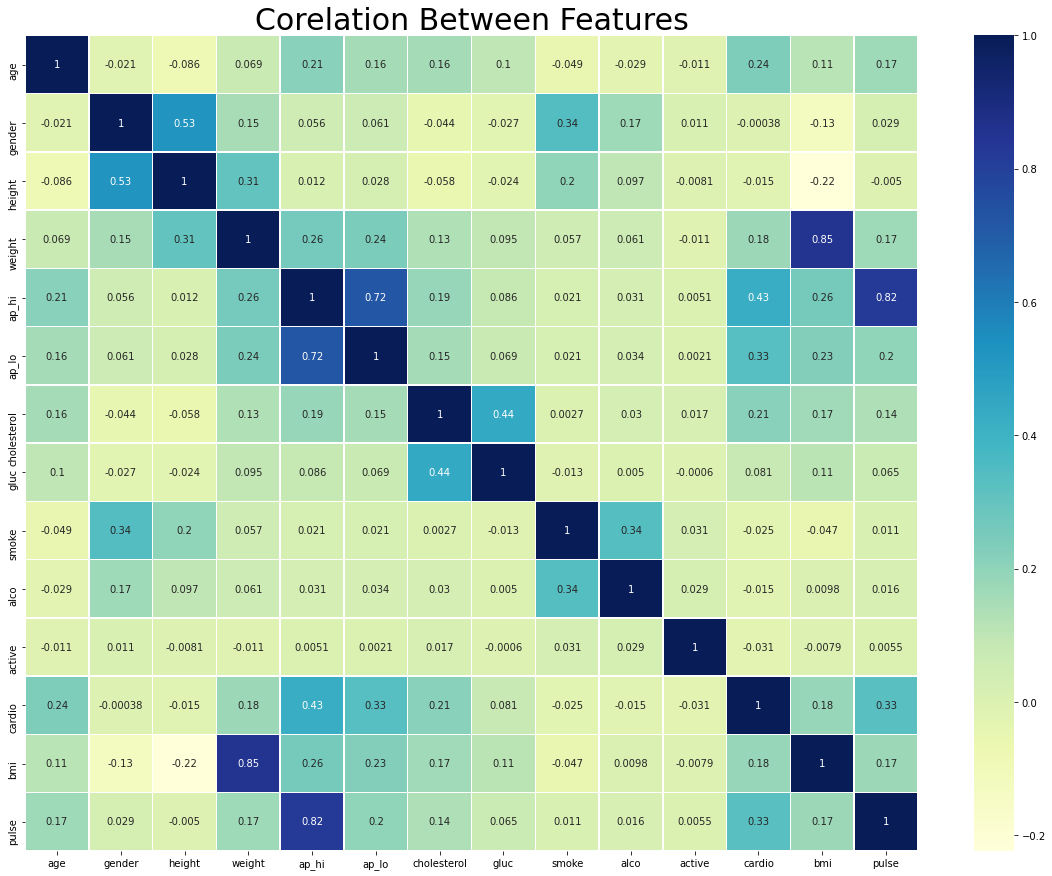

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 15) 
sns.heatmap(cleaned_data.corr(), annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Corelation Between Features', fontsize = 30)
plt.show()

In [ ]:
cleaned_data['cardio'].value_counts()

1    32404
0    31534
Name: cardio, dtype: int64

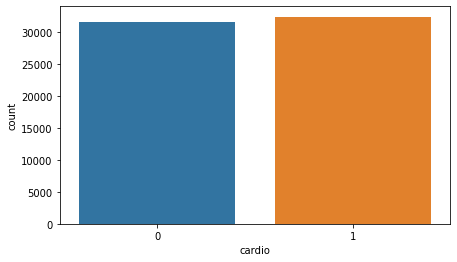

In [ ]:
plt.figure(figsize=(7,4))
sns.countplot(cleaned_data['cardio'])

In [ ]:
#cleaned_data = cleaned_data[:200]

X = cleaned_data.drop(['cardio'], axis =1)
y = cleaned_data['cardio']

In [ ]:
X.head()

age  gender    height    weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   50       2  5.123964  4.127134    110     80            1     1      0   
1   55       1  5.049856  4.442651    140     90            3     1      0   
2   51       1  5.105945  4.158883    130     70            3     1      0   
3   48       2  5.129899  4.406719    150    100            1     1      0   
4   47       1  5.049856  4.025352    100     60            1     1      0   

   alco  active        bmi  pulse  
0     0       1  21.967120   30.0  
1     0       1  34.927679   50.0  
2     0       0  23.507805   60.0  
3     0       1  28.710479   50.0  
4     0       0  23.011177   40.0

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from costcla.metrics import cost_loss

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# 0 is good, 1 is bad
#fp, fn, tp, tn
fp = np.full((y_test.shape[0],1), 1)
fn = np.full((y_test.shape[0],1), 4)
tp = np.zeros((y_test.shape[0],1))
tn = np.zeros((y_test.shape[0],1))
cost_matrix = np.hstack((fp, fn, tp, tn))

target_names = ['negative', 'sick']

**Sample Weights**

without weights
Counter({1: 22685, 0: 22071})
              precision    recall  f1-score   support

    negative       0.68      0.69      0.69      9463
        sick       0.70      0.69      0.69      9719

    accuracy                           0.69     19182
   macro avg       0.69      0.69      0.69     19182
weighted avg       0.69      0.69      0.69     19182

Loss 15117

[[6570 3056]
 [2893 6663]]


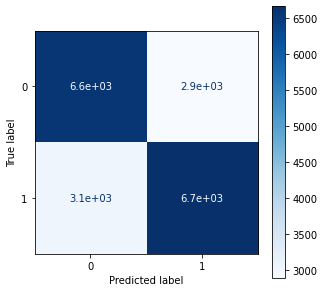

In [ ]:
print("without weights")
from collections import Counter
print(Counter(y_train))
clf = RandomForestClassifier(n_estimators=100, random_state=0)
#clf = SVC(kernel='linear', probability=False, C=1)
#clf = DecisionTreeClassifier()
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred, target_names=target_names))
loss_without_weights = cost_loss(y_test, y_pred, cost_matrix)
print("Loss %d\n" %loss_without_weights)
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides

from sklearn.metrics import plot_confusion_matrix
target = list(set(cleaned_data['cardio'].to_list()))
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None,ax=ax)


with weights
              precision    recall  f1-score   support

    negative       0.68      0.70      0.69      9463
        sick       0.70      0.67      0.69      9719

    accuracy                           0.69     19182
   macro avg       0.69      0.69      0.69     19182
weighted avg       0.69      0.69      0.69     19182

Loss : 15455

[[6652 3161]
 [2811 6558]]


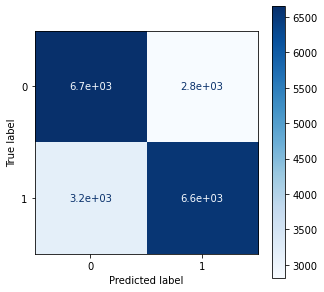

In [ ]:
print("\nwith weights")
# now create the sample weights according to y
weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 1)] = 4;
weights[np.where(y_train == 0)] = 1;
#print(data.DESCR)

model = clf.fit(x_train, y_train, weights)
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred, target_names=target_names))
loss_with_weights = cost_loss(y_test, y_pred, cost_matrix)
print("Loss : %d\n" %loss_with_weights)
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides

target = list(set(cleaned_data['cardio'].to_list()))
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None,ax=ax)

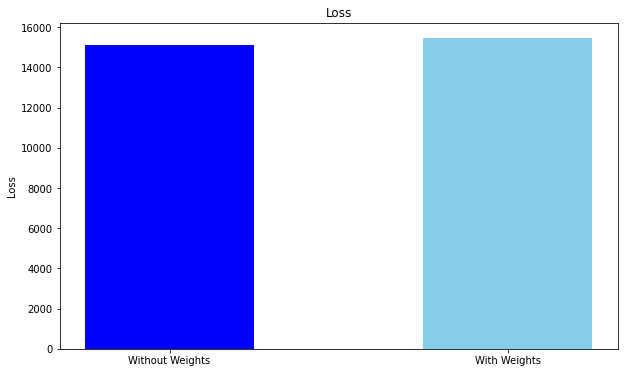

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))  
# x-coordinates of left sides of bars 
left = [1, 2]
  
# heights of bars
height = [loss_without_weights, loss_with_weights]
  
# labels for bars
tick_label = ['Without Weights', 'With Weights']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label, width = 0.5, color = ['blue',  'skyblue'])

# naming the x-axis
#plt.xlabel('Classifiers')
# naming the y-axis
plt.ylabel('Loss')
# plot title
plt.title('Loss')
  
# function to show the plot
plt.show()

**Minimizing the expected cost**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from costcla.models import BayesMinimumRiskClassifier


print("no cost minimization")
clf = RandomForestClassifier(random_state=0, n_estimators=100)
model = clf.fit(x_train, y_train)
pred_test = model.predict(x_test)
print(classification_report(y_test, pred_test, target_names=target_names))
loss_no_minimization = cost_loss(y_test, pred_test, cost_matrix)
print("Loss no cost minimization : %d\n" %loss_no_minimization)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides

print("=========================================================================\n")

print("no calibration")
clf = RandomForestClassifier(random_state=0, n_estimators=100)
model = clf.fit(x_train, y_train)
prob_test = model.predict_proba(x_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names=target_names))
loss_no_cali = cost_loss(y_test, pred_test, cost_matrix)
print("Loss no calibration : %d\n" %loss_no_cali)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides

print("=========================================================================\n")

print("\nsigmoid calibration")
clf = RandomForestClassifier(random_state=0, n_estimators=100)
cc = CalibratedClassifierCV(clf, method="sigmoid", cv=3)
model = cc.fit(x_train, y_train)
prob_test = model.predict_proba(x_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names=target_names))
loss_sigmoid = cost_loss(y_test, pred_test, cost_matrix)
print("Loss sigmoid calibration :  %d\n" %loss_sigmoid)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides
print("=========================================================================\n")

print("\nisotonic calibration")
clf = RandomForestClassifier(random_state=0, n_estimators=100)
cc = CalibratedClassifierCV(clf, method="isotonic", cv=3)
model = cc.fit(x_train, y_train)
prob_test = model.predict_proba(x_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names=target_names))
loss_plat_scaling = cost_loss(y_test, pred_test, cost_matrix)
print("Loss nisotonic calibration : %d\n" %loss_plat_scaling)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides


no cost minimization
              precision    recall  f1-score   support

    negative       0.68      0.69      0.69      9463
        sick       0.70      0.69      0.69      9719

    accuracy                           0.69     19182
   macro avg       0.69      0.69      0.69     19182
weighted avg       0.69      0.69      0.69     19182

Loss no cost minimization : 15117

[[6570 3056]
 [2893 6663]]

no calibration
              precision    recall  f1-score   support

    negative       0.76      0.31      0.44      9463
        sick       0.58      0.90      0.70      9719

    accuracy                           0.61     19182
   macro avg       0.67      0.61      0.57     19182
weighted avg       0.67      0.61      0.58     19182

Loss no calibration : 10215

[[2968  930]
 [6495 8789]]


sigmoid calibration
              precision    recall  f1-score   support

    negative       0.84      0.12      0.21      9463
        sick       0.53      0.98      0.69      9719

    a

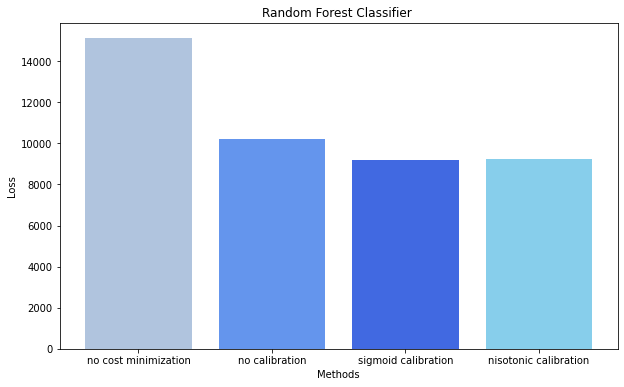

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6)) 
# x-coordinates of left sides of bars 
left = [1, 2, 3, 4]
  
# heights of bars
height = [loss_no_minimization, loss_no_cali, loss_sigmoid, loss_plat_scaling]
  
# labels for bars
tick_label = ['no cost minimization', 'no calibration', 'sigmoid calibration', 'nisotonic calibration']
  
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label, width = 0.8, color = ['lightsteelblue', 'cornflowerblue', 'royalblue', 'skyblue'])
  
# naming the x-axis
plt.xlabel('Methods')
# naming the y-axis
plt.ylabel('Loss')
# plot title
plt.title('Random Forest Classifier ')
  
# function to show the plot
plt.show()